In [2]:
import random
import os
import urllib3
import pandas as pd
from pandas import Series
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imageio
from matplotlib.lines import Line2D

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

import data_retreiver
import time_adjusted_price as money
print(dir(data_retreiver))
from datetime import date

['DATASETS', 'DATA_PATH', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'download_datasets', 'download_file', 'load_csv_datasets', 'os', 'pd', 'urllib3']


In [2]:
data_retreiver.download_datasets()

In [16]:
(all_sales, fam_core) = data_retreiver.load_csv_datasets("all_parcel_sales", "single_family_core")
fam_ids = set(fam_core.index.values)

def yearFromDateString(datestr):
    d = date.fromisoformat(datestr)
    return d.year


all_sales["Year"] = all_sales["Date"].apply(yearFromDateString)

all_sales["Price_Inflated"] = all_sales.apply(
    lambda row: money.inflate(row.Price, row.Year),
    axis = 1
)

fam_sales = all_sales[all_sales.index.isin(fam_ids)]
#fam_sales = fam_sales[fam_sales["Price"] > 0.0]


In [17]:
sum(fam_sales_nonzero["Price_Inflated"].isna())

0

In [18]:
fam_sales_nonzero = fam_sales[fam_sales["Price"] > 0.0]
all_sales_years = sorted(list(fam_sales_nonzero["Year"].value_counts().index))


In [20]:
year_sales = pd.DataFrame(columns=["Year", "Total Sales", "Median_Price", "Mean_Price", "Price_STD", "Top2Percent","Median_Price_Inflated", "Mean_Price_Inflated", "Price_STD_Inflated", "Top2Percent_Inflated"])
MEDIAN_2020 = 306000
fam_sales_nonzero = fam_sales[fam_sales["Price"] > 0.0]
for y in all_sales_years:
    data = fam_sales_nonzero[fam_sales_nonzero["Year"] == y]
    prices = data["Price"].values
    prices_inflated = data["Price_Inflated"].values

    record = {
        "Year": int(y),
        "Total Sales": len(data),
        "Median_Price": int(np.median(prices)),
        "Mean_Price": int(np.mean(prices)),
        "Price_STD": int(np.std(prices)),
        "Top2Percent": int(np.quantile(prices, 0.98)),
        "Median_Price_Inflated": int(np.median(prices_inflated)),
        "Mean_Price_Inflated": int(np.mean(prices_inflated)),
        "Price_STD_Inflated": int(np.std(prices_inflated)),
        "Top2Percent_Inflated": int(np.quantile(prices_inflated, 0.98)),
    }
    year_sales = year_sales.append(record, ignore_index = True)

#year_sales["Year"] = year_sales["Year"].astype("str")
year_sales = year_sales.set_index("Year")
year_sales


,Total Sales,Median_Price,Mean_Price,Price_STD,Top2Percent,Median_Price_Inflated,Mean_Price_Inflated,Price_STD_Inflated,Top2Percent_Inflated
Year,,,,,,,,,
1900,10,54300,61233,44728,140712,1456869,1642892,1200069,3775306
1911,12,1,1,0,1,27,27,0,27
1912,1,1,1,0,1,26,26,0,26
1914,1,1,1,0,1,25,25,0,25
1915,1,1400,1400,0,1400,36022,36022,0,36022
...,...,...,...,...,...,...,...,...,...
2016,3257,240000,298935,321634,713380,259200,322850,347365,770450
2017,3376,252500,283108,150587,650000,267650,300095,159622,689000
2018,3196,272000,301040,131844,645000,282880,313082,137118,670800


In [28]:
year_sales.to_csv("year_sales.csv")
fam_sales.to_csv("single_family_sales.csv")

In [21]:

MEDIAN_2020 = 306000
def time_adjust_sales_price(inflated_sales_price, year):
    if(inflated_sales_price < 1):
        return 0.0
    median_year = year_sales.loc[year]["Median_Price_Inflated"]
    median_difference = MEDIAN_2020 - median_year
    return inflated_sales_price + median_difference

fam_sales["Price_Time_Adjusted"] = fam_sales.apply(
    lambda row: time_adjust_sales_price(row["Price_Inflated"], row["Year"]),
    axis=1
)


Year
1900    1642892
1911         27
1912         26
1914         25
1915      36022
         ...   
2016     322850
2017     300095
2018     313082
2019     336798
2020     334240
Name: Mean_Price_Inflated, Length: 92, dtype: object

50
1975 567690.0
62
1976 627993.0
83
1977 695823.0
89
1978 716679.7000000001
83
1979 726706.0
59
1980 743125.0
55
1981 658638.0
67
1982 591000.0
82
1983 595190.0
94
1984 649740.0
98
1985 643000.0
100
1986 700290.0
95
1987 702000.0
94
1988 798027.5
96
1989 728100.0
102
1990 848440.0
106
1991 904475.0
105
1992 904475.0
94
1993 731250.0
88
1994 684563.0
87
1995 662562.0
100
1996 1701861.0
106
1997 1892520.0
112
1998 1892520.0
117
1999 1892520.0
122
2000 1794240.0
134
2001 1828237.0
136
2002 1828237.0
133
2003 1828237.0
120
2004 1746719.9999999998
104
2005 1783500.0
88
2006 1982213.0
78
2007 1249677.79
68
2008 970020.0
64
2009 1136620.0
66
2010 1688721.0
75
2011 1987680.0000000002
86
2012 1987680.0000000002
93
2013 1987680.0000000002
96
2014 1832800.0000000002
100
2015 1832800.0000000002
99
2016 907120.0
97
2017 868020.0
85
2018 860320.0


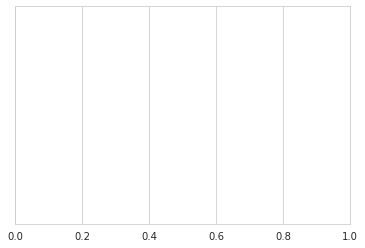

In [23]:
def drop_top_values(values, percent_drop):
    n = len(values)
    values_to_drop = int(n * (percent_drop / 100)) + 1
    print(values_to_drop)
    values_sorted = list(sorted(values))
    return values_sorted[:-values_to_drop]

def drop_top_values_lim(values, top_lim):
    return [v for v in values if v < top_lim]

def getPricesInYear(df, year):
    salesInYear = df[df["Year"] == year]
    prices = salesInYear["Price"].values
    return prices

def getPricesInYear_Inflated(df, year):
    salesInYear = df[df["Year"] == year]
    prices = salesInYear["Price_Time_Adjusted"].values
    return prices

def plot_inflated_sales_prices(df, year_start, year_end, inflated = True):
    years = list(range(year_start, year_end+1))
    prices = []

    if(inflated):
        file_name = f"anim/inf_sales_{year_start}_{year_end}.png"
        title = f"Madison Home Sales Prices {year_start} - {year_end} (Inflated)"
        xlab = "Price (2020 Dollars, Thousands)"
        for y in years:
            prices.extend(getPricesInYear_Inflated(df, y))
    else:
        file_name = f"anim/sales_{year_start}_{year_end}.png"
        title = f"Madison Home Sales Prices {year_start} - {year_end}"
        xlab = "Price (Thousands)"
        for y in years:
            prices.extend(getPricesInYear(df, y))


    prices_drop_top = drop_top_values(prices, 1)
    prices_drop_top = drop_top_values_lim(prices_drop_top, 2000000)
    print(year_start, max(prices_drop_top))
    median = np.median(prices_drop_top)


    sns.set_style('whitegrid')
    p = sns.kdeplot(np.array(prices_drop_top), bw=0.15)
    p.set_title(title)
    p.set_xlim(0, 1000000)
    p.set_xlabel(xlab)
    p.get_yaxis().set_visible(False)
    p.set_xticks(np.arange(0, 1000000, 100000))
    p.set_xticklabels(["0", "100K", "200K", "300K", "400K", "500K", "600K", "700K", "800K", "900K"])
    p.axvline(x=median, c="orange")
    
    legend_elements = [Line2D([0], [0], color='orange', lw=4, label='Median')]
    p.legend(handles=legend_elements)

    #print(dir(p))
    p.figure.savefig(file_name, dpi=200)
    p.cla()
    return file_name

def plot_inflated_sales_prices_animation(df, inflated = True):
    frame_names = []
    images = []
    curr_base_year = 1975
    last_base_year = 2018
    while(curr_base_year <= last_base_year):
        end_year = curr_base_year + 2
        frame_names.append(plot_inflated_sales_prices(df, curr_base_year, end_year, inflated))
        curr_base_year += 1

    for frame_filename in frame_names:
        images.append(imageio.imread(frame_filename))
        images.append(imageio.imread(frame_filename))
        images.append(imageio.imread(frame_filename))
    if(inflated):
        imageio.mimsave('home_sales_inflated_7year.gif', images)
    else:
        imageio.mimsave('home_sales_7year.gif', images)


#plot_inflated_sales_prices_animation(fam_sales, True)
fam_sales_g0 = fam_sales[fam_sales["Price_Time_Adjusted"] > 0]
plot_inflated_sales_prices_animation(fam_sales_g0, True)

In [26]:
np.mean(fam_sales["Price_Time_Adjusted"])



330416.52290929836

In [13]:
print()

In [14]:

print()

In [15]:
print()

In [138]:
#core = core.drop(columns=["industrial_sites_near", "commercial_sites_near", "vacant_sites_near"])
(all_assessments) = data_retreiver.load_csv_datasets("all_parcel_assessments")

all_assessments = all_assessments[0]
all_assessments["Parcel"] = all_assessments["Parcel"].astype("str")
all_assessments.set_index("Parcel", inplace=True)


assessment_dict = all_assessments["Total_Assessment"].to_dict()

core["Total_Assessment"] = core.index.map(assessment_dict)
core

,XRefParcel,Address,PropertyClass,PropertyUse,AssessmentArea,MoreThanOneBuild,HomeStyle,YearBuilt,Bedrooms,FullBaths,...,StreetID,MaxConstructionYear,XCoord,YCoord,SHAPESTArea,SHAPESTLength,lat,lon,property_kind,Total_Assessment
Parcel,,,,,,,,,,,,,,,,,,,,,
71002107665,71002104033,121 Metro Ter Unit 109,Residential,Condominium,5115,NaN,Garden,2006,2,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,163900.0
71002107673,71002104033,121 Metro Ter Unit 201,Residential,Condominium,5115,NaN,Garden,2006,2,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,170200.0
71002107681,71002104033,121 Metro Ter Unit 202,Residential,Condominium,5115,NaN,Garden,2006,3,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,190800.0
71002107699,71002104033,121 Metro Ter Unit 203,Residential,Condominium,5115,NaN,Garden,2006,1,1,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,118000.0
71002107706,71002104033,121 Metro Ter Unit 204,Residential,Condominium,5115,NaN,Garden,2006,2,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,163200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71002107615,71002104033,121 Metro Ter Unit 104,Residential,Condominium,5115,NaN,Garden,2006,2,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,152400.0
71002107623,71002104033,121 Metro Ter Unit 105,Residential,Condominium,5115,NaN,Garden,2006,2,2,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,160200.0
71002107631,71002104033,121 Metro Ter Unit 106,Residential,Condominium,5115,NaN,Garden,2006,1,1,...,5686,2006,851889.992,492200.3022,189753.7883,1842.05604,43.100414,-89.268753,condo,127400.0


In [141]:
def getLatLonPairs(df):
    result = []
    for pid, record in df.iterrows():
        lat = record["lat"]
        lon = record["lon"]
        result.append((lat, lon))
    return result
    

def getNumNearProperties(base_lat, base_lon, relevant_locations):
    count = 0
    for loc_lat, loc_lon in relevant_locations:
        lat_delta = abs(base_lat - loc_lat)
        lon_delta = abs(base_lon - loc_lon)
        if(lat_delta < 0.02 and lon_delta < 0.02):
            d = distance.distance((base_lat, base_lon), (loc_lat, loc_lon)).km
            if(d < 1):
                count += 1
    return count

def getNearDataframe(targetdf, sampledf, property_kind, new_col_name):
    right_kind_df = sampledf[sampledf["property_kind"] == property_kind]
    relevant_locations = getLatLonPairs(right_kind_df)

    result = pd.DataFrame(columns=["Parcel", new_col_name])
    records = []
    rowindex = 0
    for pid, content in targetdf.iterrows():
        if(rowindex % 1000 == 0):
            print(rowindex, end=", ")
        rowindex += 1
        home_lat = content["lat"]
        home_lon = content["lon"]
        count = getNumNearProperties(home_lat, home_lon, relevant_locations)
        records.append({"Parcel": str(pid), new_col_name: count})
    return result.append(records)

core_fam = core[core["property_kind"] == "single_family_home"]
core_fam_smol = core_fam.sample(2000)
near_vacant_sites = getNearDataframe(core_fam, core, "vacant", "near_vacant_sites")

    


In [ ]:
def property_kind(property_class, property_use):
    if(not isinstance(property_use, str)):
        print("uncategorized", property_class, property_use)
        return "uncategorized"
    if(property_class == "Residential" and property_use == "Single family"):
        return "single_family_home"
    if(property_class == "Residential" and property_use == "Condominium"):
        return "condo"
    if(property_class == "Industrial" and property_use == "Manufacturing"):
        return "industrial"
    if(property_class == "Agricultural" and property_use == "Agricultural"):
        return "agricultural"
    if("unit" in property_use.lower()):
        return "multi_unit"
    if("vacant" in property_use.lower()):
        return "vacant"
    if(property_class == "Commercial"):
        return "commercial"
    print("uncategorized", property_class, property_use)
    return "uncategorized"

property_kind_df = pd.DataFrame(columns=["Parcel", "property_kind"])
property_kind_df.set_index("Parcel")

row_num = 0
for i, parcel_record in raw.iterrows():
    if(row_num % 4000 == 0):
        print(row_num / 80500)
    row_num += 1
    #print(i, parcel_record["PropertyClass"], parcel_record["PropertyUse"])
    kind = property_kind(parcel_record["PropertyClass"], parcel_record["PropertyUse"])
    record = {"Parcel": i, "property_kind": kind}
    property_kind_df = property_kind_df.append(record, ignore_index=True)
property_kind_df

